In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyvisa as visa
import time
import metodos_labo as labo

plt.style.use('./informes.mplstyle')

#### Identificar termocuplas

In [ ]:
rm = visa.ResourceManager()
print(rm.list_resources())

multi_up = rm.open_resource('GPIB0::22::INSTR')
multi_down = rm.open_resource('GPIB0::23::INSTR')

try:
    print(multi_up.query_ascii_values('MEASURE:VOLT:DC?')[0] * 1e3)
    print(multi_down.query_ascii_values('MEASURE:RESistance? 1000')[0])
    
except:
    print('HUBO ERROR')
multi_up.close()
multi_down.close()

#### Medir temperatura ambiente

In [ ]:
rm = visa.ResourceManager()
multi_down = rm.open_resource('GPIB0::23::INSTR')

try:
    
    duracion = 10  # s
    
    t = []
    R = []
    
    t0 = time.time()
    while time.time() - t0 <= duracion:
        t.append(time.time() - t0)
        R.append(multi_down.query_ascii_values('MEASURE:RESistance? 100')[0])
    
    t = np.array(t)  # s
    R = np.array(R)  # Ohm
    
    df = pd.DataFrame({'Tiempo [s]' : t,
                        'Resistencia [Ohm]' : R})
    
    labo.save(df, 'temp_amb', './Mediciones/Clase 2')
    
    
except:
    print('HUBO ERROR')
multi_down.close()

#### Medir temperaturas

In [ ]:
rm = visa.ResourceManager()

multi_up = rm.open_resource('GPIB0::22::INSTR')
multi_down = rm.open_resource('GPIB0::23::INSTR')


try:
    
    # MEDIR
    
    t = []  # s
    V = []  # V
    R = []  # Ohm
    duracion = 20  # s
    
    t0 = time.time()
    while time.time() - t0 <= duracion:
        t.append(time.time() - t0)
        medicion_V = multi_up.query_ascii_values('MEASURE:VOLT:DC?')[0]
        medicion_R = multi_down.query_ascii_values('MEASURE:RESistance? 1000')[0]
        V.append(medicion_V)
        R.append(medicion_R)
    
    t = np.array(t)  # s
    V = np.array(V) * 1e3  # mV
    R = np.array(R)  # Ohm
    
    
    # GUARDAR DATOS
    
    df = pd.DataFrame({'Tiempo [s]' : t,
                        'Tension [mV]' : V,
                        'Resistencia [Ohm]' : R})
    
    labo.save(df, f'cal_termocupla2_t{duracion}', './Mediciones/Clase 2')
    
    
    # GRAFICAR
    
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].set_ylabel('Tensión [mV]')
    ax[1].set_ylabel('Temperatura [°C]')
    ax[1].set_xlabel('Tiempo [s]')
    
    ax[0].plot(t, V)
    ax[1].plot(t, labo.R2C(R), 'C1')
    
    
except:
    print('HUBO ERROR')
multi_up.close()
multi_down.close()

plt.show()

#### Calibración

Calibracion termocupla 1
popt = [24.73021774 28.29016809]
popt_sd = [0.02285388 0.01531391]
P_value = 0.0

Calibracion termocupla 2
popt = [23.99098017 27.70258529]
popt_sd = [0.01622848 0.01125288]
P_value = 0.0



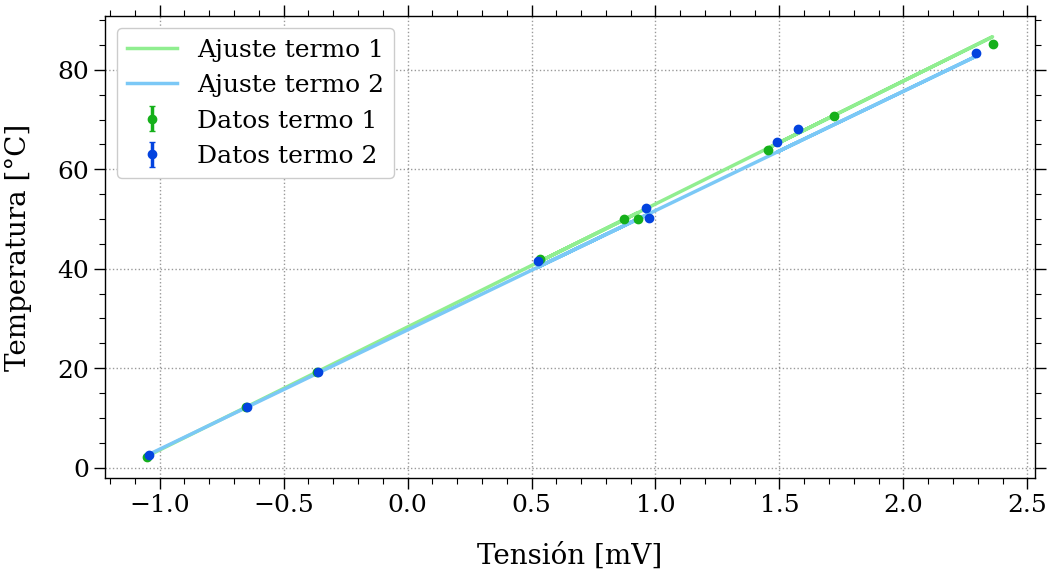

In [11]:
n_mediciones = 9
calibracion = lambda V, m, b: m*V + b

fig, ax = plt.subplots()
ax.set_xlabel('Tensión [mV]')
ax.set_ylabel('Temperatura [°C]')

for n_termo in range(1, 3):
    
    R = []
    V = []
    R_sd = []
    V_sd = []
    
    for i in range(n_mediciones):
        if i != 0:
            df = pd.read_csv(f'./Mediciones/Clase 2/cal_termocupla{n_termo}_t20({i}).csv')
        else:
            df = pd.read_csv(f'./Mediciones/Clase 2/cal_termocupla{n_termo}_t20.csv')
        
        # Tension
        V_temp = df['Tension [mV]'].values
        V_bar = np.mean(V_temp)
        V_est_err = np.sum((V_temp - V_bar)**2) / (len(V_temp) - 1)
        # V_lec_err = labo.reading_1V*V_temp
        # V_range_err = labo.range_1V*V_temp
        
        V.append(V_bar)
        V_sd.append(np.sqrt(V_est_err**2))
        
        # Resistencia
        R_temp = df['Resistencia [Ohm]'].values
        R_bar = np.mean(R_temp)
        R_est_err = np.sum((R_temp - R_bar)**2) / (len(R_temp) - 1)
        # R_lec_err = labo.reading_100Ohm*R_temp
        # R_range_err = ((i < 5) * labo.range_100Ohm + (i >= 5) * labo.range_1kOhm) * R_temp
        
        R.append(R_bar)
        R_sd.append(np.sqrt(R_est_err**2))
    
    V = np.array(V)
    T = labo.R2C(np.array(R))
    V_sd = np.array(V_sd)
    T_sd = np.array(R_sd) * labo.cal_pt100
    
    
    # Cuadrados minimos
    
    popt, pcov, P = labo.least_squares(calibracion, V, T, T_sd)
    print(f'Calibracion termocupla {n_termo}')
    print(f'popt = {popt}')
    print(f'popt_sd = {np.sqrt(np.diag(pcov))}')
    print(f'P_value = {P}\n')
    
    
    # Figuras y plots
    
    if n_termo == 1:
        ax.errorbar(V, T, yerr=T_sd, color='xkcd:green', marker='o', ls='',
                    label=f'Datos termo {n_termo}', capsize=2, capthick=1)
    else:
        ax.errorbar(V, T, yerr=T_sd, color='xkcd:blue', marker='o', ls='',
                    label=f'Datos termo {n_termo}', capsize=2, capthick=1)
    
    ax.plot(V, calibracion(V, *popt), label=f'Ajuste termo {n_termo}')


ax.legend()
plt.show()